In [1249]:
from nodejs_wheel import corepack
# This notebook is going to explore the evolution of volatility across GME
%pip install pyarrow
%pip install clickhouse_connect

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1250]:
import clickhouse_connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [1251]:
client = clickhouse_connect.get_client(host="clickhouse.icc", port=8123, username="default", password="")

local timezone Mountain Daylight Time may return unexpected times due to Daylight Savings Time/Summer Time differences


In [1252]:
trades = client.query_df("SELECT * FROM trades_historic.gme")

In [1253]:
import pytz

tz = pytz.timezone('Europe/Rome')

trades["price"] = trades["price"].astype(float)
trades["timestamp"] = pd.to_datetime(trades["timestamp"], utc=True)
trades = trades.set_index("timestamp")
trades = trades.tz_convert(tz)

trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1347040 entries, 2016-10-01 10:22:05+02:00 to 2025-07-22 00:00:34+02:00
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   id          1347040 non-null  int32         
 1   buysell     1347040 non-null  string        
 2   status      1347040 non-null  string        
 3   marketcode  1347040 non-null  string        
 4   flowdate    1347040 non-null  datetime64[ns]
 5   quantity    1347040 non-null  uint32        
 6   price       1347040 non-null  float64       
 7   operator    1347040 non-null  string        
dtypes: datetime64[ns](1), float64(1), int32(1), string(4), uint32(1)
memory usage: 82.2 MB


In [1254]:
# Get the mean for price traded within that period
trades_resampled = trades["price"].resample("30min").mean()
trades_resampled = trades_resampled.ffill()
returns = trades_resampled.pct_change()
trades = trades.reset_index()

Text(0, 0.5, 'Pct. Returns')

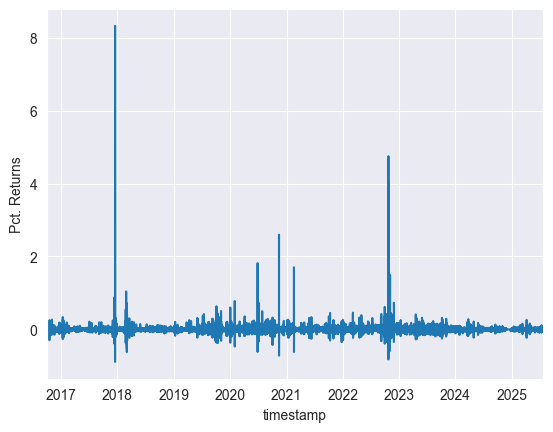

In [1255]:
returns.plot()
plt.ylabel("Pct. Returns")

Text(0, 0.5, 'Annualized Volatility %')

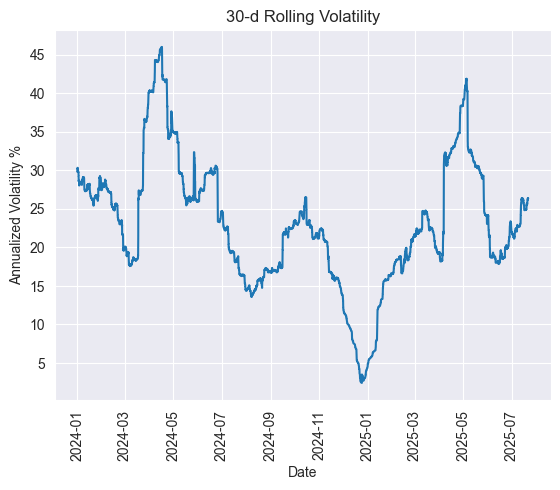

In [1256]:
# 30d * 48 (30min sections) / d
# Assume 10 holidays per year for trading
vol = returns.rolling(window=30*48).std() * np.sqrt(355)

plt.title("30-d Rolling Volatility")
# Get volatility for 2025
vol2024 = vol[vol.index >= pd.to_datetime("2024-01-01", utc=True)]

sns.lineplot(vol2024 * 100)

plt.xticks(rotation=90)
plt.locator_params(axis='y', nbins=15)

plt.xlabel("Date")
plt.ylabel("Annualized Volatility %")

In [1257]:
# Load AGS data
ags = client.query_df("SELECT * FROM trades_historic.gme_ags")

In [1258]:
ags['timestamp'] = pd.to_datetime(ags['timestamp'], utc=True)
ags['price'] = ags['price'].astype(float)
ags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39637 entries, 0 to 39636
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   id          39637 non-null  int32              
 1   buysell     39637 non-null  string             
 2   status      39637 non-null  string             
 3   timestamp   39637 non-null  datetime64[ns, UTC]
 4   marketcode  39637 non-null  string             
 5   flowdate    39637 non-null  datetime64[ns]     
 6   quantity    39637 non-null  uint32             
 7   price       39637 non-null  float64            
 8   operator    39637 non-null  string             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int32(1), string(4), uint32(1)
memory usage: 2.4 MB


In [1259]:
# SELECT ONLY MGP (day ahead products)
ags_da = ags[(ags["marketcode"] == "MGP-ASTA") & (ags['buysell'] == "S")]

In [1260]:
ags_da[ags_da["operator"] != "SRG TSO"]["operator"].value_counts().head(20)

operator
ENGIE ITALIA SPA                     1982
ENEL GLOBAL TRADING SPA              1960
Energi Danmark A/S                   1900
DANSKE COMMODITIES A/S               1852
ELECTRADE S.P.A.                     1751
ENET ENERGY SA                       1398
UTILITA' S.P.A.                      1184
DUFERCO Energia S.p.A.               1119
ERTENERGY OÜ                          927
NITOR ENERGY A/S                      860
ECO SVILUPPO SRL                      819
MFT ENERGY A/S                        764
ENI GLOBAL ENERGY MARKETS SPA         664
BKW ENERGIE AG                        619
GREEN NETWORK S.P.A.                  544
INTERCONTINENTAL COMMODITIES FZCO     541
BLUENERGY GROUP SPA                   511
COBBLESTONE ENERGY DMCC               510
REPOWER ITALIA SPA                    446
CENTREX ITALIA SPA                    390
Name: count, dtype: Int64

In [1261]:
ags_cols = ['buysell', 'flowdate', 'quantity', 'price']
ags_da = ags_da.groupby("flowdate").last()

In [1262]:
# Get the average clearing price based on flow date for DA markets
trades_da_settlement_vwap = trades[((trades['flowdate'].dt.date - trades['timestamp'].dt.date) == pd.to_timedelta(1, unit='D'))]

In [1263]:
trades_da_settlement_vwap = trades_da_settlement_vwap.set_index("timestamp")

In [1264]:
# Get trades within settlement window of 1715 to 1745
trades_da_settlement_vwap = trades_da_settlement_vwap.between_time("1715", "1745")

In [1265]:
trades_da_settlement_vwap = trades_da_settlement_vwap.groupby("flowdate").apply(
    lambda x: (x['price'] * x['quantity']).sum() / x['quantity'].sum(),
    include_groups = False
).reset_index(name='settlement_vwap')

In [1266]:
trades_da_settlement_vwap

,flowdate,settlement_vwap
0,2016-10-25,19.100000
1,2016-11-12,19.000000
2,2016-11-17,22.600000
3,2016-12-03,18.700000
4,2016-12-13,20.100000
...,...,...
2254,2025-07-17,37.754396
2255,2025-07-18,37.813852
2256,2025-07-19,36.830379
2257,2025-07-20,36.700000


In [1267]:
ags_da = ags_da.merge(trades_da_settlement_vwap, on='flowdate', suffixes=('', ''))

In [1268]:
# Since we are only counting when AGS is selling we care about AGS - SETTLEMENT to get idea of the spread
ags_da["spread"] = ags_da["price"] - ags_da["settlement_vwap"]
ags_da

,flowdate,id,buysell,status,timestamp,marketcode,quantity,price,operator,settlement_vwap,spread
0,2020-01-01,1093321,S,A,2019-12-31 12:21:28+00:00,MGP-ASTA,9600,13.750,DUFERCO Energia S.p.A.,12.712500,1.037500
1,2020-01-03,1094045,S,A,2020-01-02 12:24:03+00:00,MGP-ASTA,1200,13.400,Energi Danmark A/S,12.224359,1.175641
2,2020-01-04,1094582,S,A,2020-01-03 11:33:32+00:00,MGP-ASTA,23760,12.600,SRG TSO,13.270833,-0.670833
3,2020-01-07,1095895,S,A,2020-01-06 12:28:13+00:00,MGP-ASTA,3600,14.180,ENET ENERGY SA,14.623077,-0.443077
4,2020-01-08,1096530,S,A,2020-01-07 12:12:40+00:00,MGP-ASTA,2400,14.198,Energi Danmark A/S,14.187022,0.010978
...,...,...,...,...,...,...,...,...,...,...,...
1606,2025-07-17,2606965,S,A,2025-07-16 11:28:14+00:00,MGP-ASTA,1200,37.770,ENET ENERGY SA,37.754396,0.015604
1607,2025-07-18,2607961,S,A,2025-07-17 11:29:30+00:00,MGP-ASTA,1200,38.150,ERTENERGY OÜ,37.813852,0.336148
1608,2025-07-19,2609019,S,A,2025-07-18 11:29:48+00:00,MGP-ASTA,120,37.320,UTILITA' S.P.A.,36.830379,0.489621
1609,2025-07-20,2610475,S,A,2025-07-19 11:27:39+00:00,MGP-ASTA,7200,36.940,MFT ENERGY A/S,36.700000,0.240000


In [1269]:
DATELIMIT = pd.to_datetime("2017-01-01")

<Axes: xlabel='spread', ylabel='Count'>

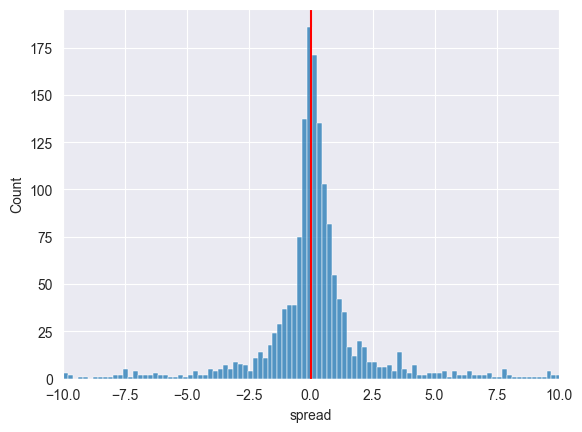

In [1290]:
# ags_da[ags_da["flowdate"] > pd.to_datetime("2024-01-01")].plot(kind="kde", )
ags_da_filtered = ags_da[ags_da["flowdate"] > DATELIMIT]

plt.axvline(x=0, color='red', linewidth=1.5, linestyle='-')
plt.gca().set_xlim(-10, 10)
sns.histplot(ags_da_filtered, x="spread", fill=True)

In [1271]:
# Get the probability of the positive spread (sell AGS buy average settlement)
prob_ags_spread_win = (ags_da_filtered['spread'] > 0).mean()
print(f'Probability of success for AGS and settlement clearing: {prob_ags_spread_win}')

Probability of success for AGS and settlement clearing: 0.5865921787709497


In [1272]:
ags_da_filtered

,flowdate,id,buysell,status,timestamp,marketcode,quantity,price,operator,settlement_vwap,spread
0,2020-01-01,1093321,S,A,2019-12-31 12:21:28+00:00,MGP-ASTA,9600,13.750,DUFERCO Energia S.p.A.,12.712500,1.037500
1,2020-01-03,1094045,S,A,2020-01-02 12:24:03+00:00,MGP-ASTA,1200,13.400,Energi Danmark A/S,12.224359,1.175641
2,2020-01-04,1094582,S,A,2020-01-03 11:33:32+00:00,MGP-ASTA,23760,12.600,SRG TSO,13.270833,-0.670833
3,2020-01-07,1095895,S,A,2020-01-06 12:28:13+00:00,MGP-ASTA,3600,14.180,ENET ENERGY SA,14.623077,-0.443077
4,2020-01-08,1096530,S,A,2020-01-07 12:12:40+00:00,MGP-ASTA,2400,14.198,Energi Danmark A/S,14.187022,0.010978
...,...,...,...,...,...,...,...,...,...,...,...
1606,2025-07-17,2606965,S,A,2025-07-16 11:28:14+00:00,MGP-ASTA,1200,37.770,ENET ENERGY SA,37.754396,0.015604
1607,2025-07-18,2607961,S,A,2025-07-17 11:29:30+00:00,MGP-ASTA,1200,38.150,ERTENERGY OÜ,37.813852,0.336148
1608,2025-07-19,2609019,S,A,2025-07-18 11:29:48+00:00,MGP-ASTA,120,37.320,UTILITA' S.P.A.,36.830379,0.489621
1609,2025-07-20,2610475,S,A,2025-07-19 11:27:39+00:00,MGP-ASTA,7200,36.940,MFT ENERGY A/S,36.700000,0.240000


In [1273]:
# Lets try to build a correlation of AGS spread with 30d rolling volatility

# 0. Get daily 30d rolling volatility
# Assume 10 holidays per year for trading -> 355 days
vol_daily_30d = returns.rolling(window=30).std() * np.sqrt(355)
vol_daily_30d = vol_daily_30d.resample('D').mean()
vol_daily_30d.index = pd.to_datetime(vol_daily_30d.index, utc=True)
vol_daily_30d.index = vol_daily_30d.index.date

# 1. Add vol to a dataframe with the spread
correl_ags_spread = ags_da_filtered.copy()
correl_ags_spread = correl_ags_spread.set_index("flowdate")
correl_ags_spread["vol_30d"] = vol_daily_30d

# 2 Get log transform of spread
correl_ags_spread["spread_log"] = correl_ags_spread["spread"].apply(np.arcsinh)

# 2. Drop if any value has NA
correl_ags_spread = correl_ags_spread.dropna(how='any')

In [1274]:
correl_ags_spread

,id,buysell,status,timestamp,marketcode,quantity,price,operator,settlement_vwap,spread,vol_30d,spread_log
flowdate,,,,,,,,,,,,
2020-01-01,1093321,S,A,2019-12-31 12:21:28+00:00,MGP-ASTA,9600,13.750,DUFERCO Energia S.p.A.,12.712500,1.037500,1.580536,0.907643
2020-01-03,1094045,S,A,2020-01-02 12:24:03+00:00,MGP-ASTA,1200,13.400,Energi Danmark A/S,12.224359,1.175641,0.665385,1.000285
2020-01-04,1094582,S,A,2020-01-03 11:33:32+00:00,MGP-ASTA,23760,12.600,SRG TSO,13.270833,-0.670833,0.332008,-0.628609
2020-01-07,1095895,S,A,2020-01-06 12:28:13+00:00,MGP-ASTA,3600,14.180,ENET ENERGY SA,14.623077,-0.443077,0.885936,-0.429728
2020-01-08,1096530,S,A,2020-01-07 12:12:40+00:00,MGP-ASTA,2400,14.198,Energi Danmark A/S,14.187022,0.010978,0.977216,0.010978
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,2605793,S,A,2025-07-15 11:29:51+00:00,MGP-ASTA,240,38.390,UTILITA' S.P.A.,37.825883,0.564117,0.070034,0.537813
2025-07-17,2606965,S,A,2025-07-16 11:28:14+00:00,MGP-ASTA,1200,37.770,ENET ENERGY SA,37.754396,0.015604,0.104562,0.015604
2025-07-18,2607961,S,A,2025-07-17 11:29:30+00:00,MGP-ASTA,1200,38.150,ERTENERGY OÜ,37.813852,0.336148,0.178225,0.330119


<Axes: xlabel='vol_30d', ylabel='spread_log'>

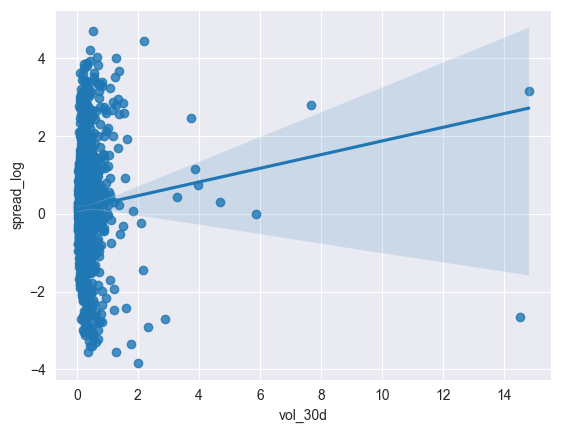

In [1275]:
sns.regplot(correl_ags_spread, x="vol_30d", y="spread_log", robust=True)

In [1276]:
# Lets pull balancing data
snam = client.query_df("SELECT * FROM balancing.snam")

In [1277]:
snam["date"] = pd.to_datetime(snam["date"], utc=True)
# Only include 2020 and further as that's where AGS provisional Y data started being reported
snam_filtered = snam[snam["date"].dt.date > DATELIMIT.date()]

In [1278]:
snam_cols = ["date", "da_y_provisional", "da_degree_days", "da_sas_imbalance", "wd_degree_days"]

# now we need to filter out the zeros in da_y_provisional
snam_filtered = snam_filtered[snam_filtered["da_y_provisional"] != 0]

# Filter by dates and take the latest value for da_y_provisional
snam_filtered = snam_filtered[snam_cols].groupby("date").last()

In [1279]:
snam_filtered_joined = snam_filtered.copy()
snam_filtered_joined.reset_index()

snam_filtered_joined["flowdate"] = snam_filtered_joined.index + pd.to_timedelta(1, unit='D')
snam_filtered_joined["flowdate"] = pd.to_datetime(snam_filtered_joined["flowdate"], format='%Y-%m-%d').dt.tz_localize(None)
snam_filtered_joined = snam_filtered_joined.set_index("flowdate")
snam_filtered_joined

,da_y_provisional,da_degree_days,da_sas_imbalance,wd_degree_days
flowdate,,,,
2020-01-01,117629.3837,11.700,0.0,13.000
2020-01-02,30768.0000,12.400,0.0,11.500
2020-01-03,30744.0000,11.400,0.0,12.200
2020-01-04,-23760.0000,10.800,0.0,11.500
2020-01-05,-36288.0000,11.200,0.0,11.000
...,...,...,...,...
2025-10-20,-68352.0000,4.055,0.0,3.360
2025-10-21,-8496.0000,4.441,0.0,3.811
2025-10-22,4104.0000,3.686,0.0,4.363


In [1280]:
snam_filtered_joined = snam_filtered_joined.reset_index()
correl_ags_spread = correl_ags_spread.reset_index()

In [1281]:
snam_filtered_joined = snam_filtered_joined.merge(correl_ags_spread.reset_index(), on="flowdate", suffixes=('', '_ags'))

In [1282]:
cols = ['da_y_provisional', 'wd_degree_days', 'vol_30d', 'spread_log']
snam_filtered_joined = snam_filtered_joined[cols]

In [1283]:
# Convert wd_degree_days into a float
snam_filtered_joined = snam_filtered_joined.astype({"wd_degree_days": "float64"})

In [1300]:
# make vol_30d a log transform to deal with assymettry of the distribution
snam_filtered_joined["vol_30d_log"] = snam_filtered_joined["vol_30d"].apply(np.log)
snam_filtered_joined = snam_filtered_joined.drop("vol_30d", axis=1)

<Axes: >

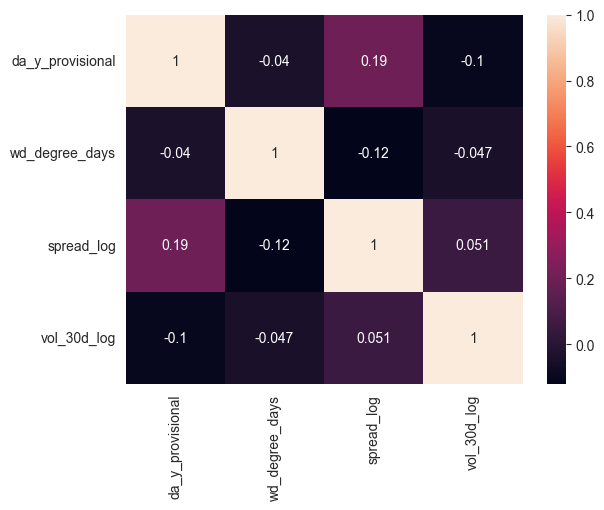

In [1301]:
sns.heatmap(snam_filtered_joined.corr(), annot=True)

<Axes: xlabel='vol_30d_log', ylabel='Count'>

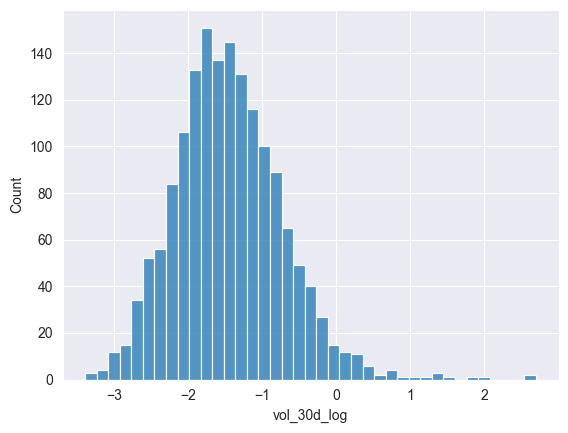

In [1303]:
sns.histplot(snam_filtered_joined, x="vol_30d_log")

In [1318]:
snam_filtered_joined_corr = snam_filtered_joined.corr()
snam_filtered_joined_corr["spread_log"]

da_y_provisional    0.190827
wd_degree_days     -0.121541
spread_log          1.000000
vol_30d_log         0.050911
Name: spread_log, dtype: float64

array([[<Axes: xlabel='da_y_provisional', ylabel='da_y_provisional'>,
        <Axes: xlabel='wd_degree_days', ylabel='da_y_provisional'>,
        <Axes: xlabel='spread_log', ylabel='da_y_provisional'>,
        <Axes: xlabel='vol_30d_log', ylabel='da_y_provisional'>],
       [<Axes: xlabel='da_y_provisional', ylabel='wd_degree_days'>,
        <Axes: xlabel='wd_degree_days', ylabel='wd_degree_days'>,
        <Axes: xlabel='spread_log', ylabel='wd_degree_days'>,
        <Axes: xlabel='vol_30d_log', ylabel='wd_degree_days'>],
       [<Axes: xlabel='da_y_provisional', ylabel='spread_log'>,
        <Axes: xlabel='wd_degree_days', ylabel='spread_log'>,
        <Axes: xlabel='spread_log', ylabel='spread_log'>,
        <Axes: xlabel='vol_30d_log', ylabel='spread_log'>],
       [<Axes: xlabel='da_y_provisional', ylabel='vol_30d_log'>,
        <Axes: xlabel='wd_degree_days', ylabel='vol_30d_log'>,
        <Axes: xlabel='spread_log', ylabel='vol_30d_log'>,
        <Axes: xlabel='vol_30d_log', ylab

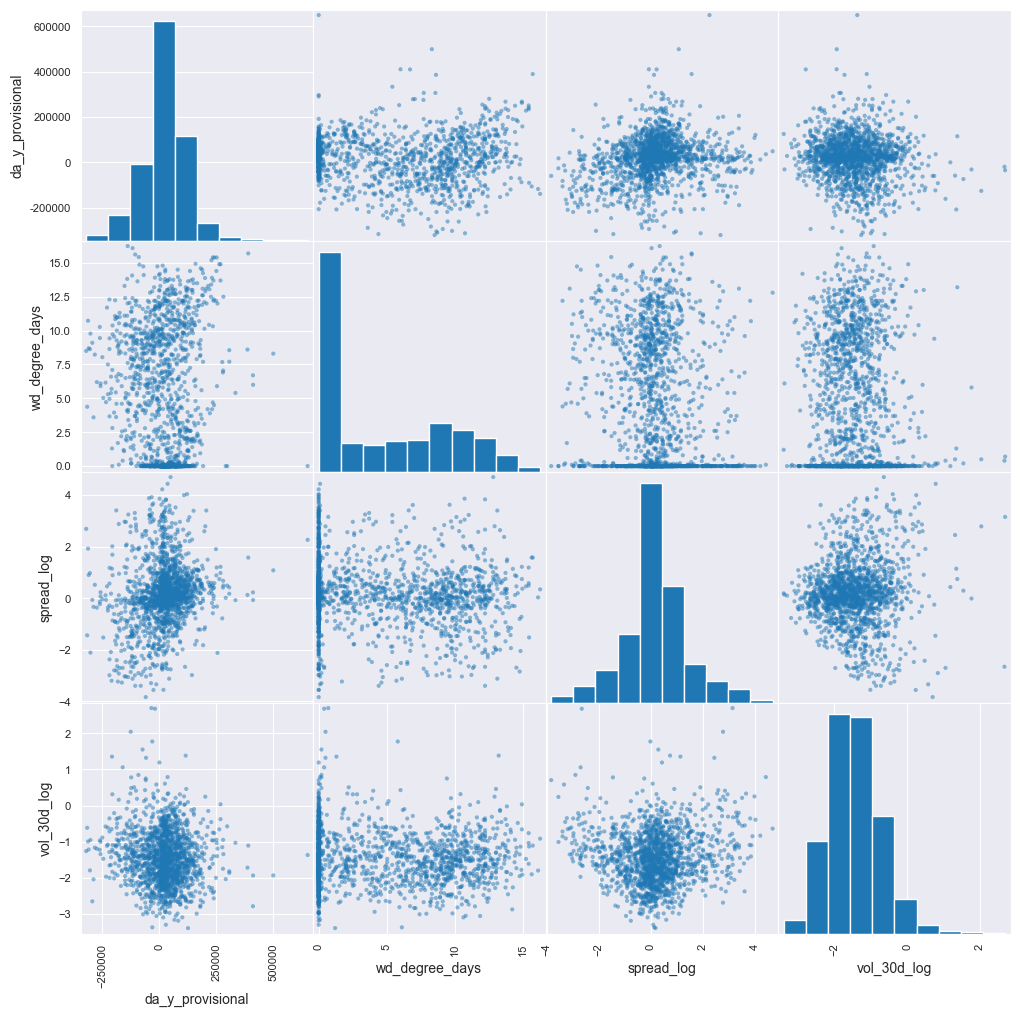

In [1320]:
from pandas.plotting import scatter_matrix

scatter_matrix(snam_filtered_joined, figsize=(12, 12))